## 16-6. 프로젝트 - Movielens 영화 SBR

이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import pandas as pd
import tensorflow
from pathlib import Path
import os
import numpy as np
import seaborn as sns

print(pd.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


```
1) 데이터 확인
$ ls -l ~/data

2) 프로젝트 폴더 생성
$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
$ ln -s ~/data/* ~/aiffel/yoochoose/data
```

In [2]:
# ! ls -l ~/data
# ! mkdir -p ~/aiffel/yoochoose
# ! ln -s ~/data/* ~/aiffel/yoochoose/data

In [6]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Timestamp']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Timestamp'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [7]:
# 전체 userid수와 아이템수
data["UserId"].nunique(), data["ItemId"].nunique()

(6040, 3706)

- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

In [8]:
# 시간변환
data["Time"] = pd.to_datetime(data["Timestamp"], unit = "s")
data["Time"]

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

### Step 1. 데이터의 전처리

---------------------------------

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

__Session 구분__


유저의 취향이 변화될 수 있으므로 그떄 그때에 맞춰서 적절한 것을 추천할 필요가 있다. 

그런데 과거의 모든 히스토리를 반영하면 지금의 취향이 왜곡 될 수 있다. 그러므로 Session 구분이 필요하다. 

In [30]:
import datetime as dt
# data["timediff"] = data.diff(periods=1)["Time"]
temp = data.groupby(["UserId"])["Time"].agg(["min", "median", "max"])
temp["median-min"] = temp["median"] - temp["min"]
temp["max-median"] = temp["max"] - temp["min"]
temp

,min,median,max,median-min,max-median
UserId,,,,,
1,2000-12-31 22:00:19,2000-12-31 22:33:59,2001-01-06 23:39:11,0 days 00:33:40,6 days 01:38:52
2,2000-12-31 21:28:44,2000-12-31 21:48:17,2000-12-31 22:02:54,0 days 00:19:33,0 days 00:34:10
3,2000-12-31 21:10:18,2000-12-31 21:22:37,2000-12-31 21:35:04,0 days 00:12:19,0 days 00:24:46
4,2000-12-31 20:18:44,2000-12-31 20:23:50,2000-12-31 20:24:42,0 days 00:05:06,0 days 00:05:58
5,2000-12-31 05:37:52,2000-12-31 06:40:08,2000-12-31 07:09:45,0 days 01:02:16,0 days 01:31:53
...,...,...,...,...,...
6036,2000-04-26 00:35:49,2000-04-26 02:39:40,2000-04-26 13:19:56,0 days 02:03:51,0 days 12:44:07
6037,2000-04-26 00:29:57,2000-04-26 03:11:40,2000-04-27 02:17:20,0 days 02:41:43,1 days 01:47:23
6038,2000-04-25 23:53:47,2000-04-26 00:06:44,2000-04-26 02:46:44,0 days 00:12:57,0 days 02:52:57


<AxesSubplot:xlabel='median-min', ylabel='max-median'>

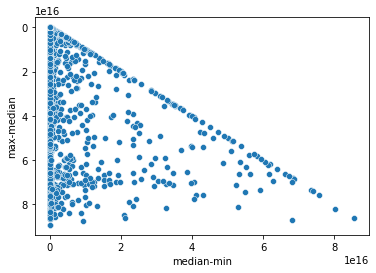

In [31]:
sns.scatterplot(data = temp, x = "median-min",y = "max-median")

> 중앙값과 최소값 차이가 0인경우가 많고 중간값 이후에 마지막 평가가까지 기간은 다양하다. 
즉 처음에 하루 평가를 몰아서 하고 한동안 안 하다가 하게되는 경우가 많은 것으로 보인다. 

In [34]:
import datetime as dt
data["iddiff"] = data.diff(periods=1)["UserId"]
data["timediff"] = data.diff(periods=1)["Time"]
session = [1]
s = 1
for i, j in zip(data["iddiff"][1:], data["timediff"][1:]):
    if (i == 0)&(j < dt.timedelta(1)):  # 1일 단위로 자름
        session.append(s)
    else :
        s +=1
        session.append(s)
        continue
data["SessionId"] = session
data

,UserId,ItemId,Rating,Timestamp,Time,timediff,iddiff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaT,NaN,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0 days 00:00:36,0.0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0 days 00:00:48,0.0,1
...,...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0 days 00:00:31,0.0,20715
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0 days 00:00:35,0.0,20715
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0 days 00:00:00,0.0,20715
1000167,6040,161,3,997454486,2001-08-10 14:41:26,0 days 00:00:22,0.0,20715


__Session Length__  
너무 많은 평가를 매긴 경우 이상치일 수 있다. 

In [35]:
# UserId Lenght
session_length = data.groupby(["SessionId"]).size()  # 유저 아이디 숫자, 즉 각 유저아이디별로 활동한 사건 수
session_length

SessionId
1         40
2         13
3        129
4         51
5         21
        ... 
20712      7
20713     14
20714      1
20715     21
20716      1
Length: 20716, dtype: int64

최소 값 :  1
최대 값 :  1849
평균 값 :  48.281955976057155
중앙 값 :  7.0
누적백분율 99.9% 값 :  903.4150000000664


<AxesSubplot:>

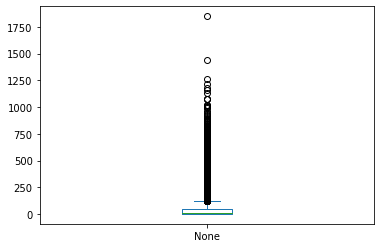

In [36]:
# 기본적인 통계값 확인
print("최소 값 : ",session_length.min())
print("최대 값 : ",session_length.max())
print("평균 값 : ",session_length.mean())
print("중앙 값 : ",session_length.median())
print("누적백분율 99.9% 값 : ",session_length.quantile(0.999))

session_length.plot(kind = "box")

평균도 165.59이고 상위 90% 를 뽑아도 400밖에 안된다. 

In [38]:
session_length.groupby(session_length).size()

1       5203
2       2232
3       1130
4        694
5        554
        ... 
1180       1
1216       1
1262       1
1442       1
1849       1
Length: 636, dtype: int64

In [39]:
length_count = session_length.groupby(session_length).size()  # 유저의 활동수를 기준으로 묶는다.
length_percent_cumsum = length_count.cumsum() / length_count.sum()  # 각 활동이 얼마나 많은 활동이었는지 누적 분포로 확인한다. 
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]  # 클릭수가 너무 많은 상위 90% 이상은 제거한다.
length_percent_cumsum_999

1      0.251159
2      0.358901
3      0.413449
4      0.446949
5      0.473692
         ...   
870    0.998793
875    0.998841
883    0.998890
888    0.998938
898    0.998986
Length: 615, dtype: float64

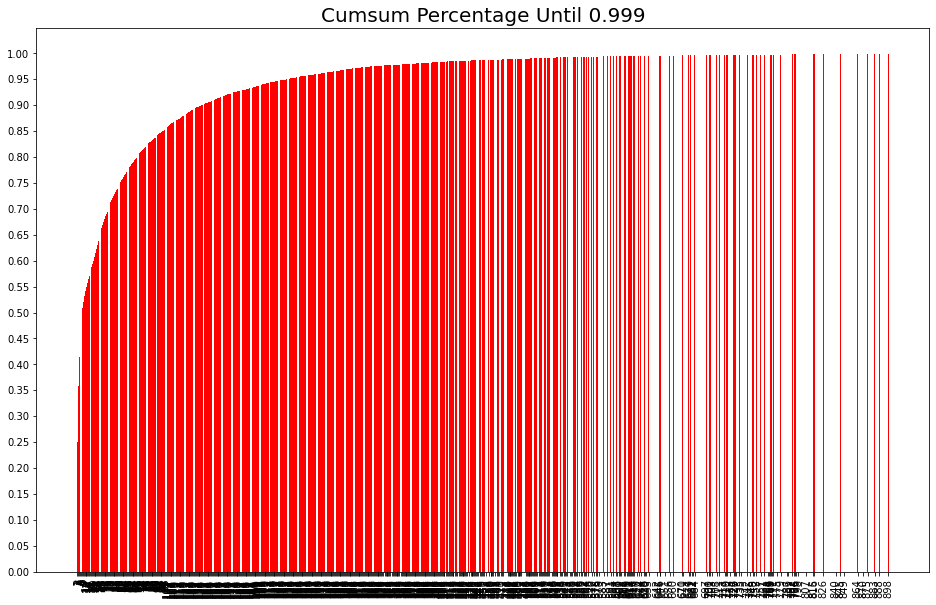

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.xticks(rotation = 90)
plt.show()

__Session Time__  

최신 트렌드를 반영하기 위해 최근 1년간 평가한 session을 활용

In [41]:
# 가장 오래된 노드와 가장 최신 노드
oldest,latest = data["Time"].min(), data["Time"].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [42]:
# month_ago = latest - dt.timedelta(730)
# data_recent = data[data["Time"] > month_ago]
# data_recent

__Data Cleaning__

In [43]:
data.shape

(1000209, 8)

In [44]:
# Rating 이 3 미만인 행은 삭제
data = data[data["Rating"] >= 3]
data

,UserId,ItemId,Rating,Timestamp,Time,timediff,iddiff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaT,NaN,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0 days 00:00:36,0.0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0 days 00:00:48,0.0,1
...,...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0 days 00:00:31,0.0,20715
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0 days 00:00:35,0.0,20715
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0 days 00:00:00,0.0,20715
1000167,6040,161,3,997454486,2001-08-10 14:41:26,0 days 00:00:22,0.0,20715


In [45]:
def cleanse_recursive(data : pd.DataFrame, shortest, least_eval) -> pd.DataFrame :
    while True : 
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_eval)
        after_len = len(data)
        if before_len == after_len:
            break
    return data
        
        
def cleanse_short_session(data : pd.DataFrame, shortest) : 
    session_len = data.groupby("SessionId").size()
    session_use = session_len[session_len >= shortest].index  # 가장 짧은 세션 이상의 session의 index 저장
    data = data[data["SessionId"].isin(session_use)]
    return data

def cleanse_unpopular_item(data : pd.DataFrame, least_eval) : 
    item_popular = data.groupby(["ItemId"]).size()
    item_use = item_popular[item_popular >= least_eval].index
    data = data[data["ItemId"].isin(item_use)]
    return data

In [46]:
# itemid 출현 빈토 최소값
data.groupby(["ItemId"]).size().min()

1

In [47]:
# 평가 수가 2개 이하인 세션은 삭제, 평가 횟수가 5회 미만인 영화도 삭제
data = cleanse_recursive(data, shortest = 2, least_eval = 5)
data

,UserId,ItemId,Rating,Timestamp,Time,timediff,iddiff,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,NaT,NaN,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0 days 00:00:36,0.0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0 days 00:00:48,0.0,1
...,...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58,0 days 00:00:31,0.0,20715
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0 days 00:00:31,0.0,20715
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0 days 00:00:35,0.0,20715
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0 days 00:00:00,0.0,20715


__Train / Valid / Test split__

In [48]:
def split_by_date(data : pd.DataFrame, n_days: int):
    final_time = data["Time"].max()
    session_last_time = data.groupby(["SessionId"])["Time"].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    
    before_date = data[data["SessionId"].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date    

In [49]:
dt.timedelta(600)

datetime.timedelta(days=600)

In [50]:
data.sort_values(by = "Time", ascending = True, inplace = True)

In [51]:
data["date"] = data["Time"].dt.date

In [52]:
train, test = split_by_date(data, n_days = 300)
train, val = split_by_date(train, n_days = 300)

In [53]:
train.shape, val.shape, test.shape

((794782, 9), (23822, 9), (12047, 9))

In [54]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [55]:
stats_info(train, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 794782
	 Sessions: 11943
	 Items: 3302
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-07-08 01:54:08

* valid Set Stats Info
	 Events: 23822
	 Sessions: 1750
	 Items: 2763
	 First Time : 2001-07-07 02:49:17
	 Last Time : 2002-05-04 02:01:59

* test Set Stats Info
	 Events: 12047
	 Sessions: 1059
	 Items: 2370
	 First Time : 2002-05-04 09:26:12
	 Last Time : 2003-02-28 17:49:50



In [56]:
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [57]:
save_path = data_path / 'processed'  # Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

--------------------------------------

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [58]:
class SessionDataset:

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId
        # 유니크 아이디 개수만큼 배열 생성
            
    def get_click_offsets(self):
        """
        세션에 수 누적값 구하기
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()  # 이게 무슨말일까?
        return offsets

In [59]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Timestamp,Time,timediff,iddiff,SessionId,date,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,-1 days +08:58:23,1.0,20709,2000-04-25,0
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,0 days 00:00:00,0.0,20709,2000-04-25,1
999873,6040,593,5,956703954,2000-04-25 23:05:54,0 days 00:00:22,0.0,20709,2000-04-25,2
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,0 days 00:00:23,0.0,20709,2000-04-25,3
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,0 days 00:00:00,0.0,20709,2000-04-25,4
999877,6040,1419,3,956704056,2000-04-25 23:07:36,0 days 00:00:00,0.0,20709,2000-04-25,5
999920,6040,213,5,956704056,2000-04-25 23:07:36,0 days 00:00:00,0.0,20709,2000-04-25,6
999967,6040,3111,5,956704056,2000-04-25 23:07:36,0 days 00:00:00,0.0,20709,2000-04-25,7
999980,6040,3505,4,956704056,2000-04-25 23:07:36,0 days 00:00:00,0.0,20709,2000-04-25,8
999868,6040,573,4,956704056,2000-04-25 23:07:36,0 days 00:01:19,0.0,20709,2000-04-25,9


In [60]:
# sessionId to idx
train_dataset.session_idx

array([    0,     1,     2, ..., 11940, 11941, 11942])

In [61]:
# 이게 무슨 의미일까?
# train_dataset.click_offsets
train_dataset.df.groupby("SessionId").size()

SessionId
1         40
2         13
3        116
4         46
5         19
        ... 
20709    133
20710     66
20711     34
20712      7
20713     13
Length: 11943, dtype: int64

In [62]:
# 1번 session에 2번 session을 더해서 점점 누적
# 그래서 그게 무슨 의미가 있을까?
train_dataset.df.groupby("SessionId").size().cumsum()[1:]  # 심지어 2번 인덱스 부터 시작

SessionId
2            53
3           169
4           215
5           234
6           377
          ...  
20709    794662
20710    794728
20711    794762
20712    794769
20713    794782
Length: 11942, dtype: int64

In [63]:
# 0 부터 시작하는 sessioid 발생건수의 누적합 배열이 생성된다.
train_dataset.click_offsets

array([     0,     40,     53, ..., 794762, 794769, 794782], dtype=int32)

__SessionDataLoader__

In [64]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [65]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Timestamp,Time,timediff,iddiff,SessionId,date,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,-1 days +08:58:23,1.0,20709,2000-04-25,0
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,0 days 00:00:00,0.0,20709,2000-04-25,1
999873,6040,593,5,956703954,2000-04-25 23:05:54,0 days 00:00:22,0.0,20709,2000-04-25,2
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,0 days 00:00:23,0.0,20709,2000-04-25,3
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,0 days 00:00:00,0.0,20709,2000-04-25,4
999877,6040,1419,3,956704056,2000-04-25 23:07:36,0 days 00:00:00,0.0,20709,2000-04-25,5
999920,6040,213,5,956704056,2000-04-25 23:07:36,0 days 00:00:00,0.0,20709,2000-04-25,6
999967,6040,3111,5,956704056,2000-04-25 23:07:36,0 days 00:00:00,0.0,20709,2000-04-25,7
999980,6040,3505,4,956704056,2000-04-25 23:07:36,0 days 00:00:00,0.0,20709,2000-04-25,8
999868,6040,573,4,956704056,2000-04-25 23:07:36,0 days 00:01:19,0.0,20709,2000-04-25,9


In [66]:
iter_ex = iter(train_data_loader)

In [67]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 40 53  4]
Label Item Idx are :       [ 1 41 54 16]
Previous Masked Input Idx are []


### Step 3. 모델 구성

------------------------------------

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

__Evaluation Metric__

In [68]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

__Model Architecture__

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [70]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [71]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [215]:
model = create_model(args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(256, 1, 3263)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    497250    
_________________________________________________________________
dropout_7 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_7 (Dense)              (256, 3263)               166413    
Total params: 663,663
Trainable params: 663,663
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

-----------------------------

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [90]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

__model_1__  

train, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

In [217]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

Evaluation:  42%|████▏     | 13/31 [00:14<00:20,  1.14s/it]


	 - Recall@20 epoch 1: 0.071214
	 - MRR@20    epoch 1: 0.015798



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.11s/it]


	 - Recall@20 epoch 2: 0.106671
	 - MRR@20    epoch 2: 0.026983



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.08s/it]


	 - Recall@20 epoch 3: 0.127103
	 - MRR@20    epoch 3: 0.030240



Evaluation:  42%|████▏     | 13/31 [00:13<00:19,  1.07s/it]


	 - Recall@20 epoch 4: 0.130108
	 - MRR@20    epoch 4: 0.032752



Evaluation:  42%|████▏     | 13/31 [00:13<00:19,  1.08s/it]


	 - Recall@20 epoch 5: 0.131010
	 - MRR@20    epoch 5: 0.033433



Evaluation:  42%|████▏     | 13/31 [00:13<00:19,  1.08s/it]


	 - Recall@20 epoch 6: 0.136719
	 - MRR@20    epoch 6: 0.033576



Evaluation:  42%|████▏     | 13/31 [00:13<00:19,  1.07s/it]


	 - Recall@20 epoch 7: 0.139423
	 - MRR@20    epoch 7: 0.034279



Evaluation:  42%|████▏     | 13/31 [00:13<00:19,  1.08s/it]


	 - Recall@20 epoch 8: 0.138221
	 - MRR@20    epoch 8: 0.034064



Evaluation:  42%|████▏     | 13/31 [00:13<00:19,  1.08s/it]


	 - Recall@20 epoch 9: 0.139423
	 - MRR@20    epoch 9: 0.034712



Evaluation:  42%|████▏     | 13/31 [00:13<00:19,  1.08s/it]

	 - Recall@20 epoch 10: 0.140024
	 - MRR@20    epoch 10: 0.035436



> val 인덱싱에서 문제가 있었는데 날짜를 늘리니까 갑자기 됐다.
아무래도 길이가 너무 짧아서 문제가 있었던거 같다. 

### Step 5. 모델 테스트

-------------------------

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [74]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# test_model(model, args, test)

### Step 6. 하이퍼 파라미터 수정

__model_2__

train, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20

In [226]:
args = Args(train, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model_2 = create_model(args)
train_model(model_2, args)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(256, 1, 3263)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1009500   
_________________________________________________________________
dropout_12 (Dropout)         (256, 100)                0         
_________________________________________________________________
dense_12 (Dense)             (256, 3263)               329563    
Total params: 1,339,063
Trainable params: 1,339,063
Non-trainable params: 0
_________________________________________________________________


Evaluation:  42%|████▏     | 13/31 [00:14<00:20,  1.15s/it]


	 - Recall@20 epoch 1: 0.098257
	 - MRR@20    epoch 1: 0.023587



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.11s/it]


	 - Recall@20 epoch 2: 0.129808
	 - MRR@20    epoch 2: 0.031707



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.09s/it]


	 - Recall@20 epoch 3: 0.135517
	 - MRR@20    epoch 3: 0.033720



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.09s/it]


	 - Recall@20 epoch 4: 0.137921
	 - MRR@20    epoch 4: 0.035972



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.10s/it]


	 - Recall@20 epoch 5: 0.139123
	 - MRR@20    epoch 5: 0.036790



Evaluation:  42%|████▏     | 13/31 [00:14<00:20,  1.12s/it]


	 - Recall@20 epoch 6: 0.140024
	 - MRR@20    epoch 6: 0.038483



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.10s/it]


	 - Recall@20 epoch 7: 0.140325
	 - MRR@20    epoch 7: 0.039432



Evaluation:  42%|████▏     | 13/31 [00:13<00:19,  1.08s/it]


	 - Recall@20 epoch 8: 0.137921
	 - MRR@20    epoch 8: 0.039832



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.08s/it]


	 - Recall@20 epoch 9: 0.139123
	 - MRR@20    epoch 9: 0.040212



Evaluation:  42%|████▏     | 13/31 [00:14<00:19,  1.09s/it]

	 - Recall@20 epoch 10: 0.134615
	 - MRR@20    epoch 10: 0.040840



In [227]:
test_model(model_2, args, test)

Evaluation:  26%|██▌       | 6/23 [00:06<00:18,  1.09s/it]

	 - Recall@20: 0.151042
	 - MRR@20: 0.042958



__model_3__  |
 batch_size = 32, session구분 1일,k = 20

In [72]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [75]:
args = Args(train, val, test, batch_size=32, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model_3 = create_model(args)
train_model(model_3, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 3302)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 100), (32, 100)]    1021200   
_________________________________________________________________
dropout_1 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (32, 3302)                333502    
Total params: 1,354,702
Trainable params: 1,354,702
Non-trainable params: 0
_________________________________________________________________


NameError: name 'train_model' is not defined

In [ ]:
test_model(model_3, args, test)